### In this notebook, we are trying to cluster all the relevant assets to test out the hypothesis that if this intrinsic cluster could potentially help to made better prediction about the ETFs / Stocks Price


In [1]:
import os
import seaborn as sns
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
## Function to processed all the data at once and carry out feature engineering
def preview(file_path, verbose = False):
    # Load in data and display
    df = pd.read_csv(file_path)[-45:]
    window_length = 14
    df['Date'] = pd.to_datetime(df['Date'])
    if verbose:
        display(df)

    # Drop all columns where min = max, there is no spread, so this is meaningless as a predictor
    if verbose:
        print(f"Irrelevant columns, min = max: {df.columns[df.min() == df.max()]}")
    df = df.loc[:, df.min() != df.max()]

    # Feature engineering
    # Year features
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month

    # Returns
    df['Returns'] = df['Close'].pct_change()
    df['5-day-Returns'] = df['Close'].pct_change(5)

    # Gains/loss/RSI
    df['Price Change'] = df['Close'].diff()
    df['Gain'] = df['Price Change'].clip(lower=0)
    df['Loss'] = -1 * df['Price Change'].clip(upper=0)

    # Average
    df['Avg Gain'] = df['Gain'].rolling(window=window_length).mean()
    df['Avg Loss'] = df['Loss'].rolling(window=window_length).mean()

    # RS/RSI
    df['RS'] = df['Avg Gain'] / df['Avg Loss']
    df['RSI'] = 100 - (100 / (1 + df['RS']))

    # Price range
    df['Daily Range'] = df['High'] - df['Low']

    # Bollinger bands
    sd_to_use = 2
    df['Moving average'] = df['Close'].rolling(window=window_length).mean()
    df['Moving average deviation'] = df['Close'].rolling(window=window_length).std()
    df['Upper Band'] = df['Moving average'] + sd_to_use*df['Moving average deviation']
    df['Lower Band'] = df['Moving average'] - sd_to_use*df['Moving average deviation']

    # Price Volume Trend
    df['PVT'] = (df['Price Change'] * df['Volume']).cumsum() # Cumulative sum to + previous day

    if verbose:
        display(df.describe())
    return df

df = preview('Data/fvc.us.txt')


In [3]:
# There're average of 20 - 22 weekdays in a month
def summarize_stock(file_path, days = 30, verbose = False):
    """
    Utilizing RSI mean and RSI std should be more careful about its context, using the single latest RSI value should be more 
    representative of the current stock's bullish / beamish state. But maybe to represent stocks in a long term state (how 
    volatile it is or how has it been performing in the past year) would be more helpful for us to cluster the stocks together

    Feature documentation:
    RSI mean: RSI (ranges from 0 - 100) indicates if a particular asset is overbought (RSI > 70) / oversold ( < 30), taking the 
              mean over a period of time meaning the tendency of this stocks being overbought/oversold over a long period of time
    RSI     : Usually we can just consider the immediate RSI, which is more representative of current stocks
    RSI std : Help us to gauge how this stocks will go over to overbought/oversold condition

    """
    df = preview(file_path, verbose = verbose).iloc[-days:,]
    features = {}
  
    # Features considered
    # Returns-mean/std = volatility
    # log mean volume
    # RSI-mean/std
    # Latest RSI
    # TODO MSCD-mean/std
    
    # All assets have data up to the newest year i.e. 2017 (to justify the clustering of the data together)
    # If all the stock prices are are listed on the different period of time, then there's no point of clustering them together
    if not df["Year"].values[-1] == 2017:
        print(file_path)
    
    y = np.sign(df['5-day-Returns'].values[-1])
    # If a particular stock has no prices percentage changes in 5 days, then we exclude it from traing
    if y == 0: 
        return None
    features['5-day-Trend'] = [y]
    features['Volatility'] = [df['Returns'].std()]
    features['Last RSI'] = [df['RSI'].values[-1]]
    features['RSI std'] = [df['RSI'].std()]
    # Increment the mean volume by 0.5 to prevent the occurence of logging 0 resulting in -infinity value
    features['Log Mean Volume'] = [np.log10(df['Volume'].mean() + 0.5)]

    return features

feat = summarize_stock('Data/fvc.us.txt')
# feat

In [10]:
# Summarize all the asset in the data 

df = pd.DataFrame(columns = ["5-day-Return", "Volatility", "Last RSI", "RSI std", "Log Mean Volume"])

for asset in os.listdir("Data"):
    if asset == "ETFs" or asset == "Stocks":
        continue
    else:
        feat = summarize_stock(f'Data/{asset}')
        if feat:
            df = pd.concat([df, pd.DataFrame(feat , index = [asset])], axis = 0)
    
display(df)

a.us.txt
aa.us.txt
aaap.us.txt
aaba.us.txt
aac.us.txt
aadr.us.txt
aal.us.txt
aamc.us.txt


C:\Users\Lee023\AppData\Local\Temp\ipykernel_31800\1518289693.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(feat , index = [asset])], axis = 0)


aame.us.txt
aan.us.txt
aaoi.us.txt
aaon.us.txt
aap.us.txt
aapl.us.txt
aat.us.txt
aau.us.txt
aav.us.txt
aaww.us.txt
aaxj.us.txt
aaxn.us.txt
ab.us.txt
abac.us.txt
abax.us.txt
abb.us.txt
abbv.us.txt
abc.us.txt
abcb.us.txt
abcd.us.txt
abco.us.txt
abdc.us.txt
abe.us.txt
abeo.us.txt
abeow.us.txt
abev.us.txt
abg.us.txt
abil.us.txt
abio.us.txt
abm.us.txt
abmd.us.txt
abr.us.txt
abrn.us.txt
abr_a.us.txt
abr_b.us.txt
abr_c.us.txt
abt.us.txt
abtx.us.txt
abus.us.txt
abx.us.txt
aby.us.txt
ac.us.txt
acad.us.txt
acbi.us.txt
acc.us.txt
acco.us.txt
acer.us.txt
acerw.us.txt
acet.us.txt
acfc.us.txt
acgl.us.txt
acglp.us.txt
ach.us.txt
achc.us.txt
achn.us.txt
achv.us.txt
acia.us.txt
acim.us.txt
aciu.us.txt
aciw.us.txt
acls.us.txt
acm.us.txt
acn.us.txt
acnb.us.txt
acor.us.txt
acp.us.txt
acre.us.txt
acrs.us.txt
acrx.us.txt
acsf.us.txt
acsi.us.txt
acst.us.txt
acta.us.txt
actg.us.txt
actx.us.txt
acu.us.txt
acv.us.txt
acwf.us.txt
acwi.us.txt
acwv.us.txt
acwx.us.txt
acxm.us.txt
acy.us.txt
adap.us.txt
adbe.us.txt


5-day-Return  Volatility   Last RSI    RSI std  Log Mean Volume  \
a.us.txt             NaN    0.006501  47.341772   9.769855         6.145230   
aa.us.txt            NaN    0.018289  26.070039  11.524425         6.562663   
aaap.us.txt          NaN    0.032283  72.510928   6.176149         6.003082   
aaba.us.txt          NaN    0.012686  68.000000   9.769492         6.797402   
aac.us.txt           NaN    0.072415  74.608696  20.068389         5.256357   
...                  ...         ...        ...        ...              ...   
ztr.us.txt           NaN    0.004742  66.181818  10.201784         4.956295   
zts.us.txt           NaN    0.011575  66.557542  21.780328         6.415947   
zumz.us.txt          NaN    0.025381  61.261261  12.546330         5.633345   
zx.us.txt            NaN    0.028255  50.963185   9.842274         4.394475   
zyne.us.txt          NaN    0.041097  77.350427  11.592259         5.761869   

             5-day-Trend  
a.us.txt            -1.0  
aa.us.txt           -1.0  
aaap.us.txt         -1.0  
aaba.us.txt          1.0  
aac.us.txt           1.0  
...                  ...  
ztr.us.txt           1.0  
zts.us.txt           1.0  
zumz.us.txt          1.0  
zx.us.txt            1.0  
zyne.us.txt          1.0  

[7407 rows x 6 columns]

-----------------------------------------2 means clustering----------------------------


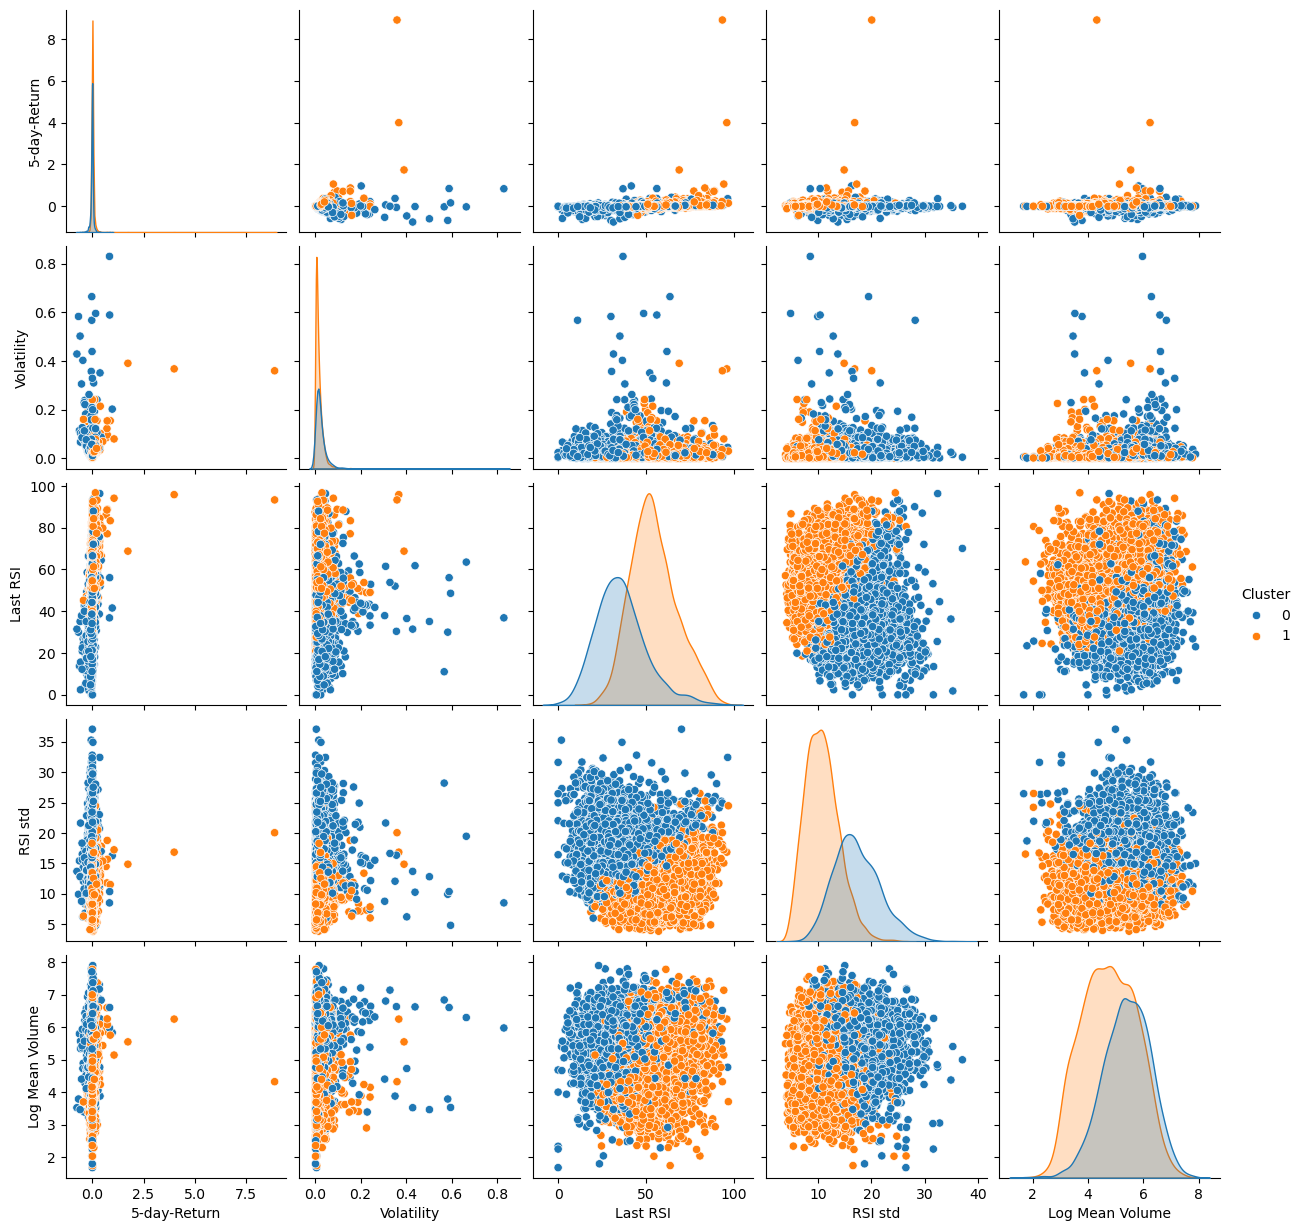

-----------------------------------------3 means clustering----------------------------


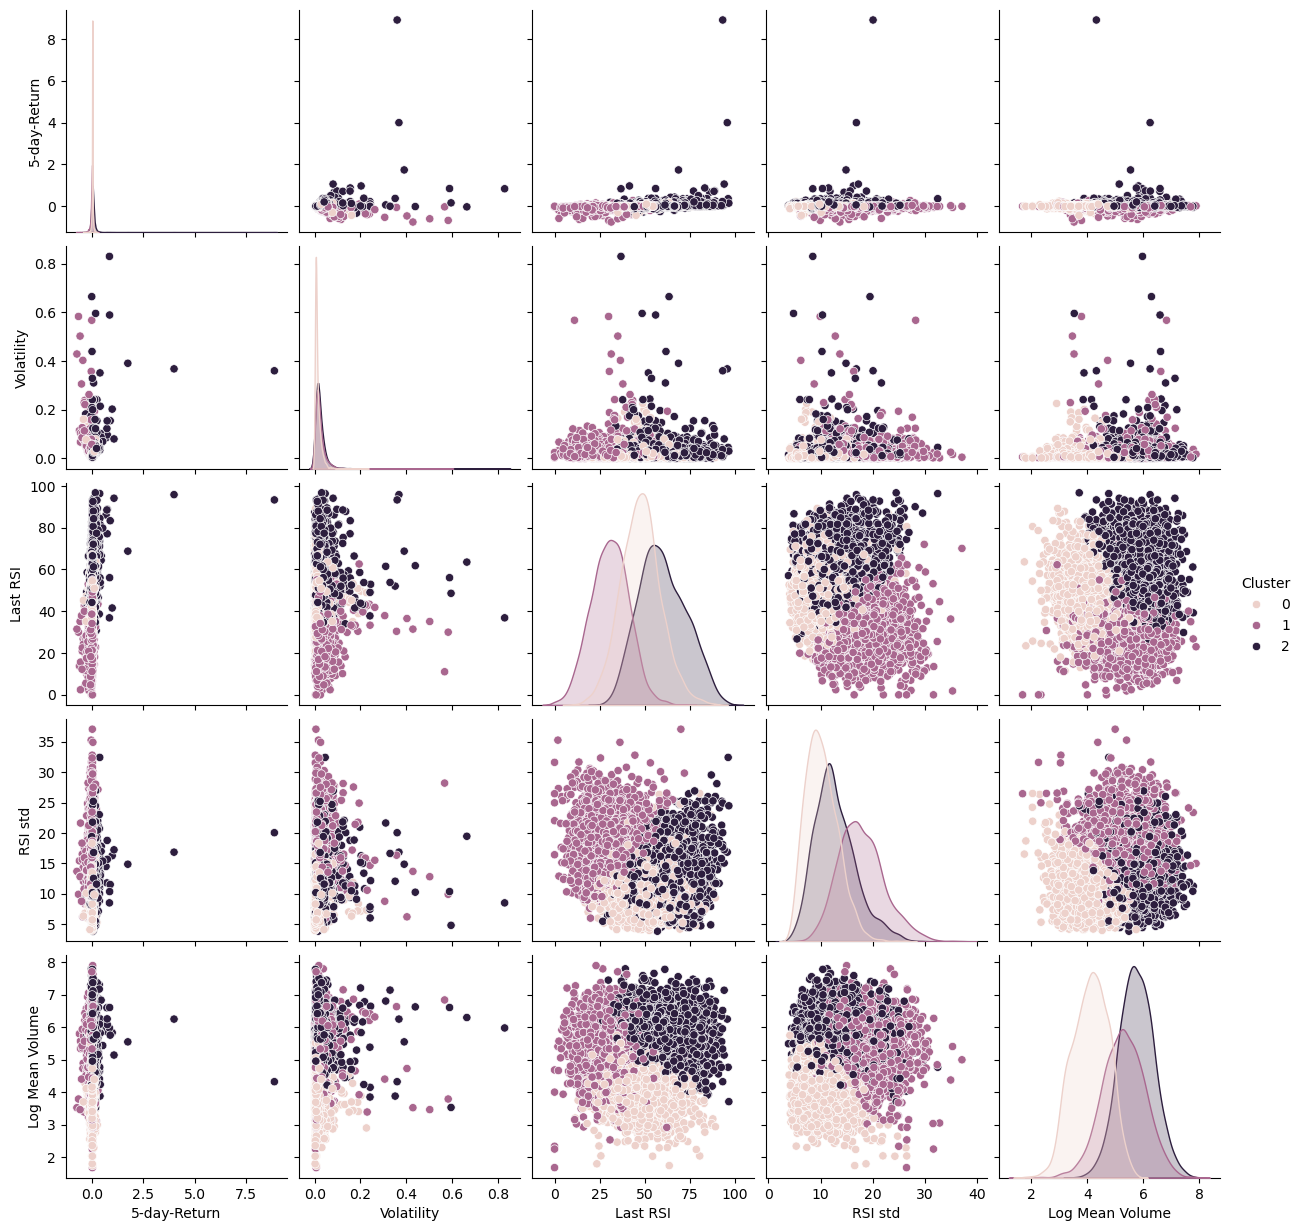

-----------------------------------------4 means clustering----------------------------


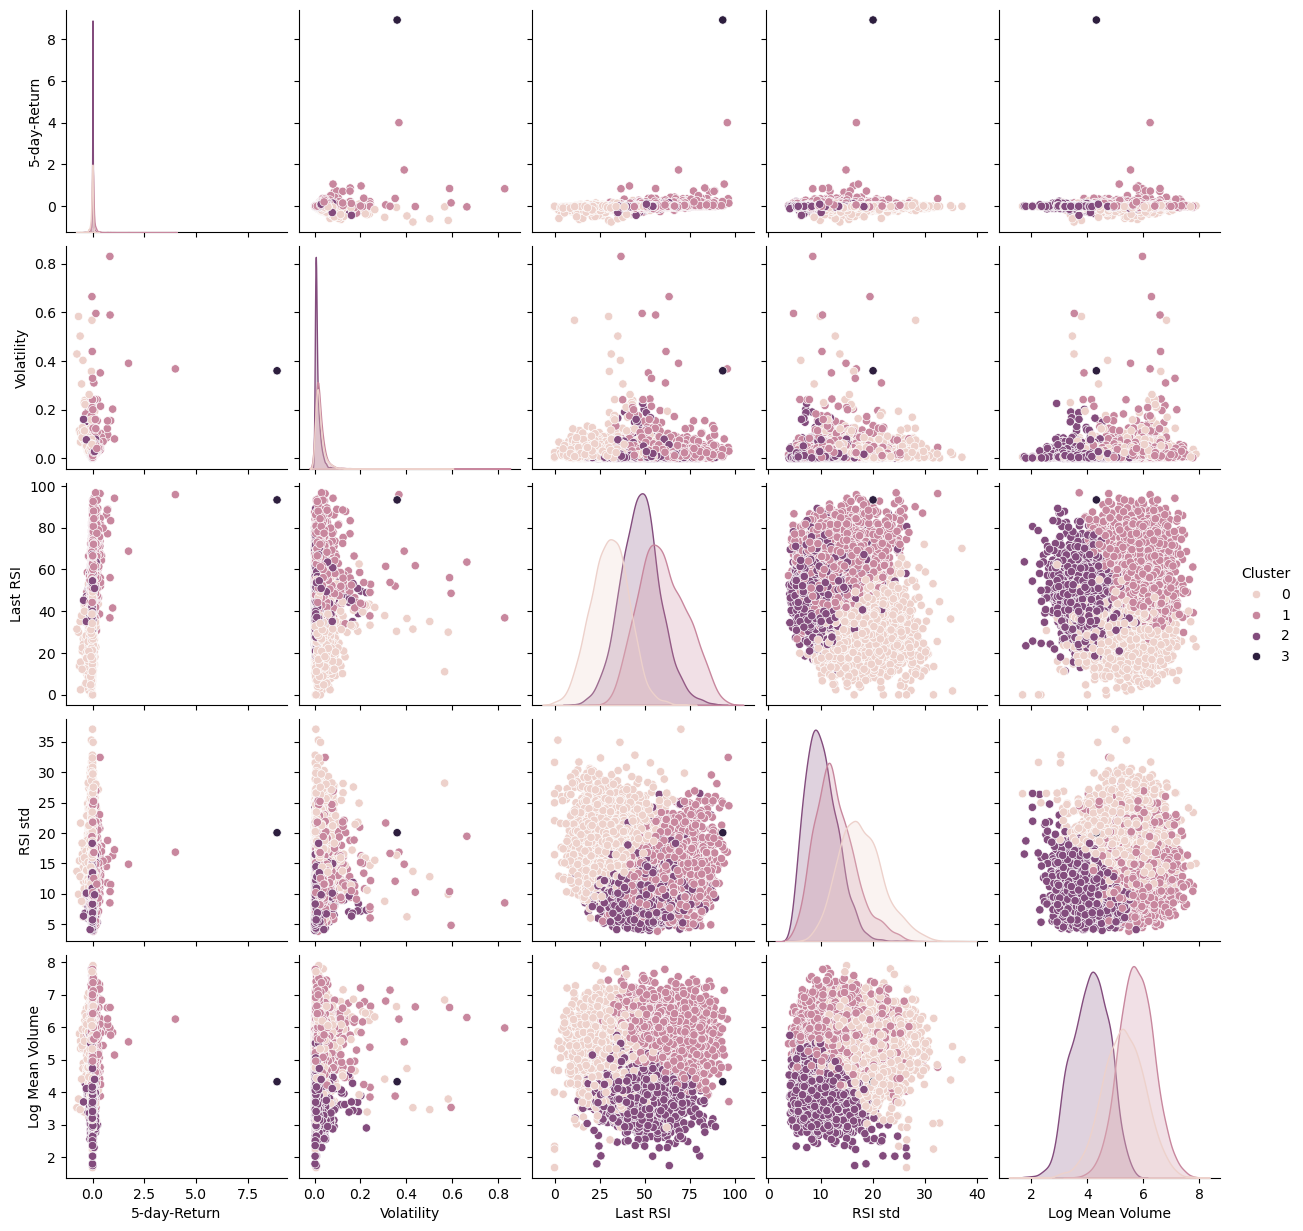

-----------------------------------------5 means clustering----------------------------


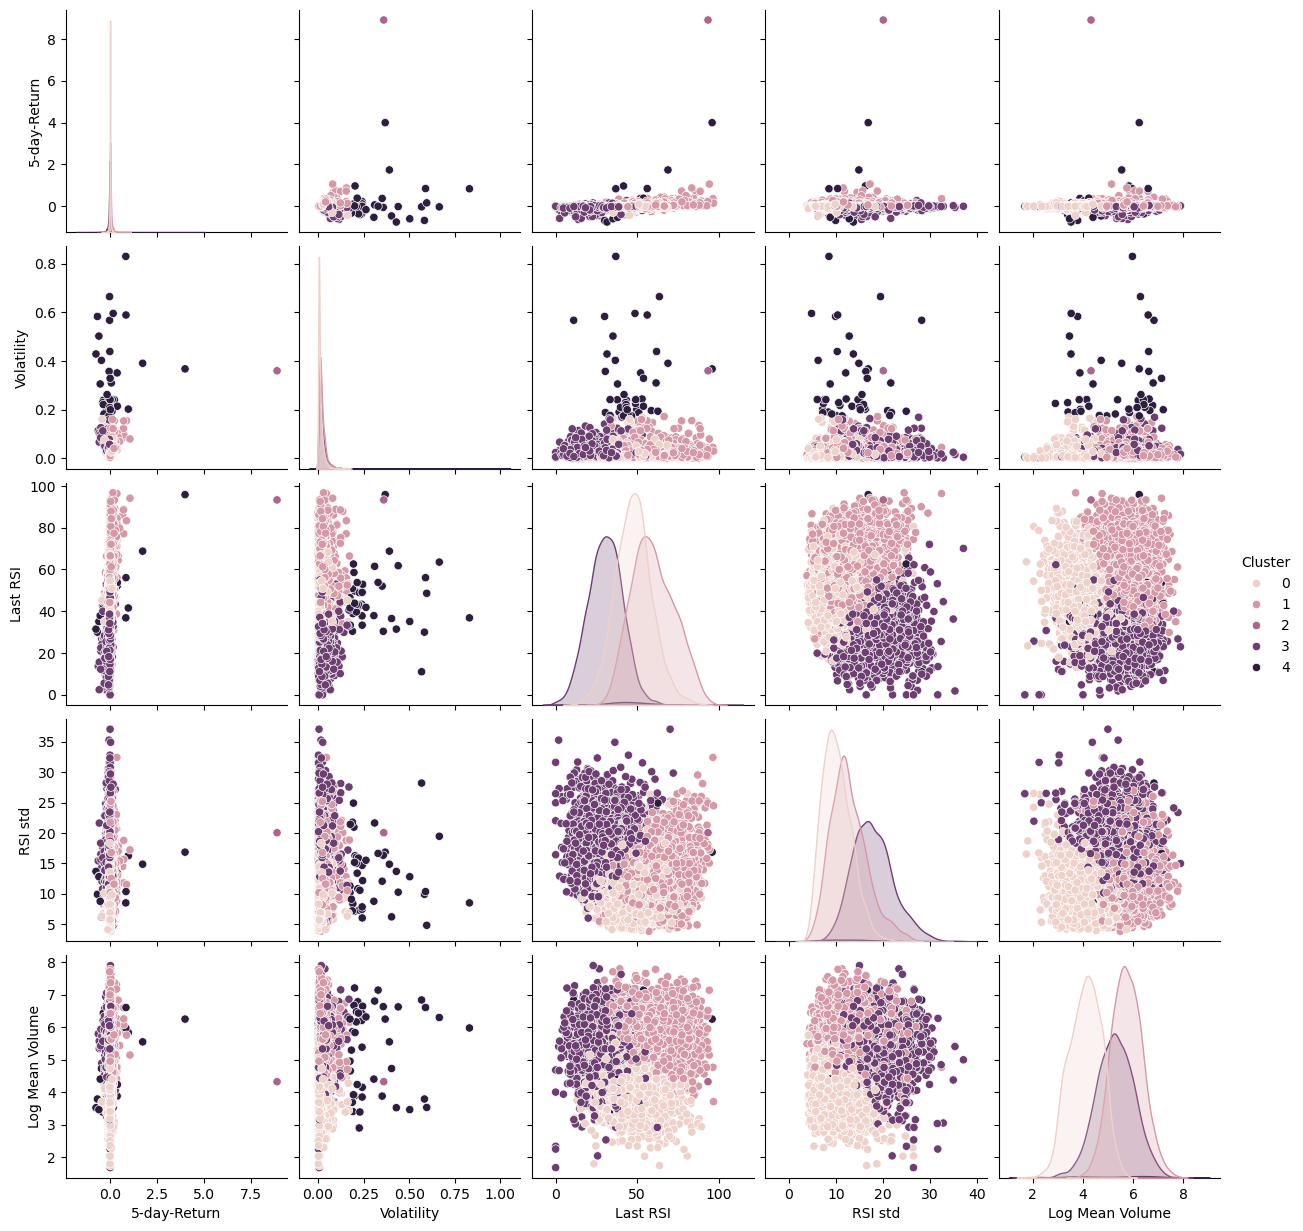

-----------------------------------------6 means clustering----------------------------


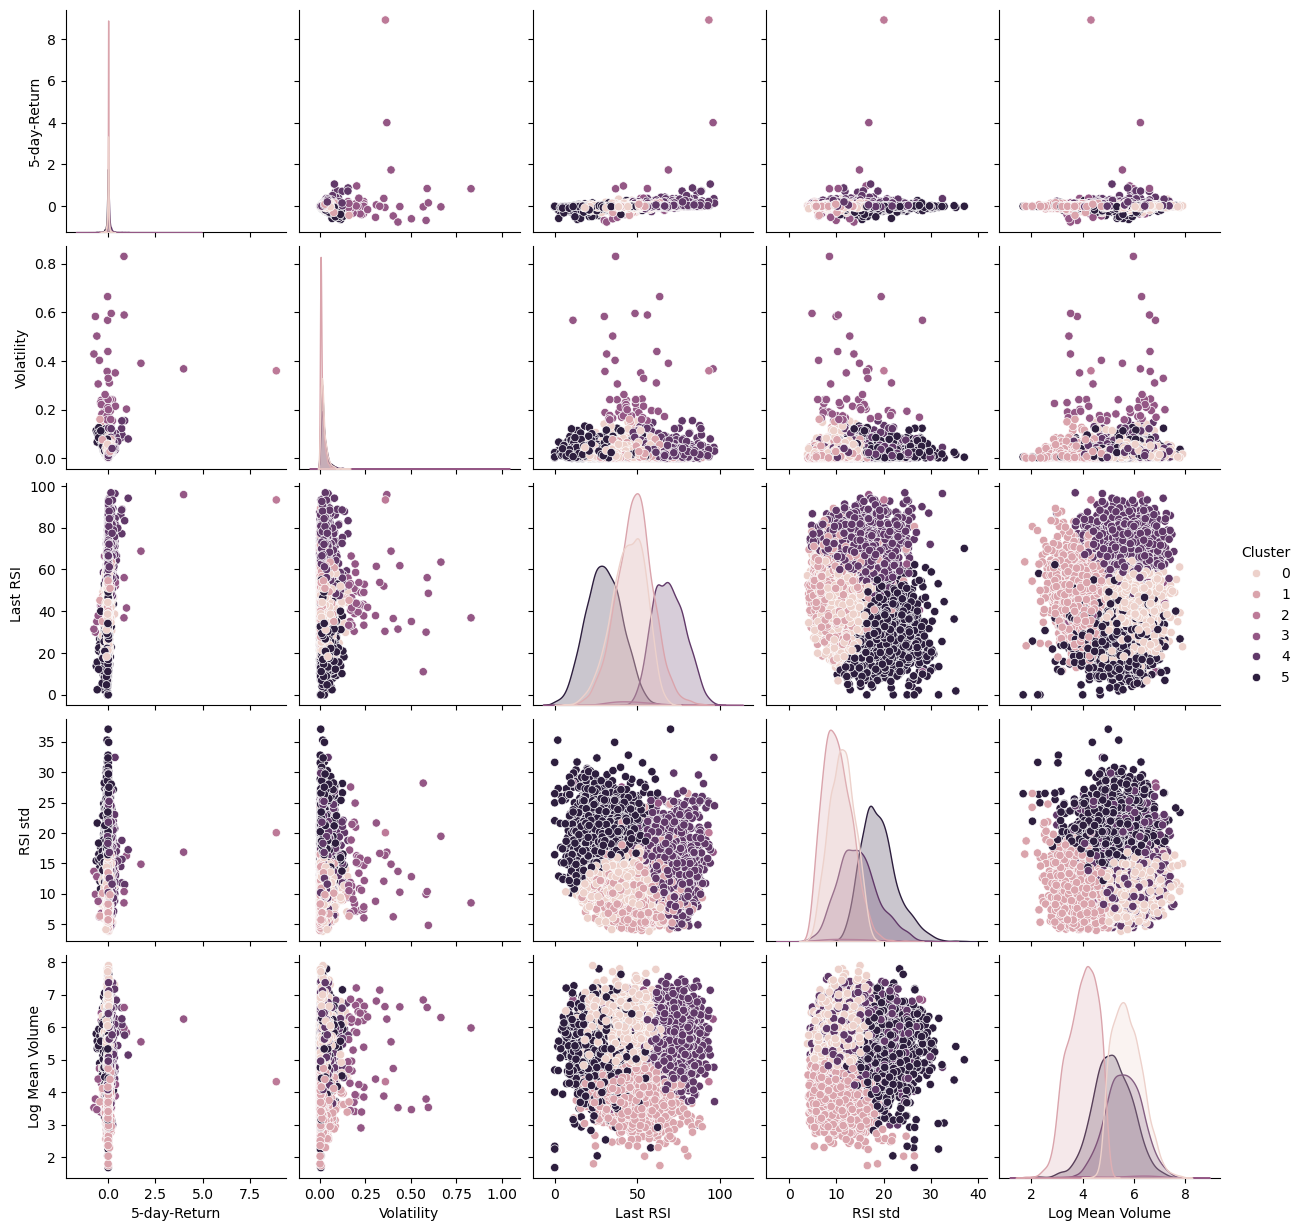

-----------------------------------------7 means clustering----------------------------


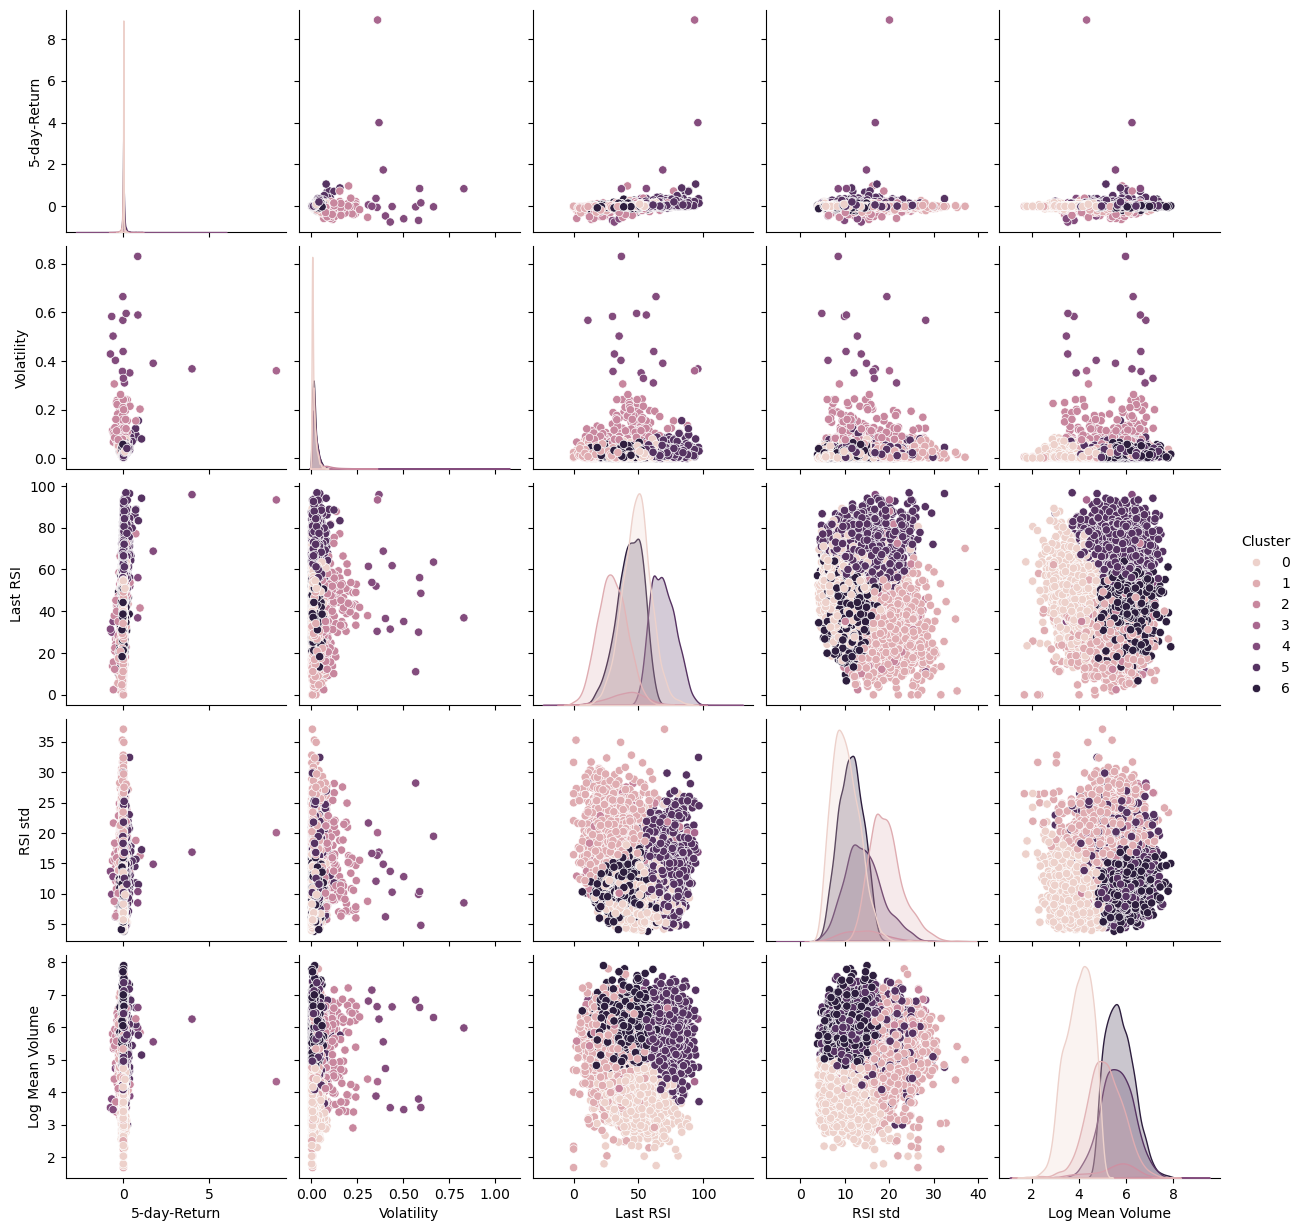

-----------------------------------------8 means clustering----------------------------


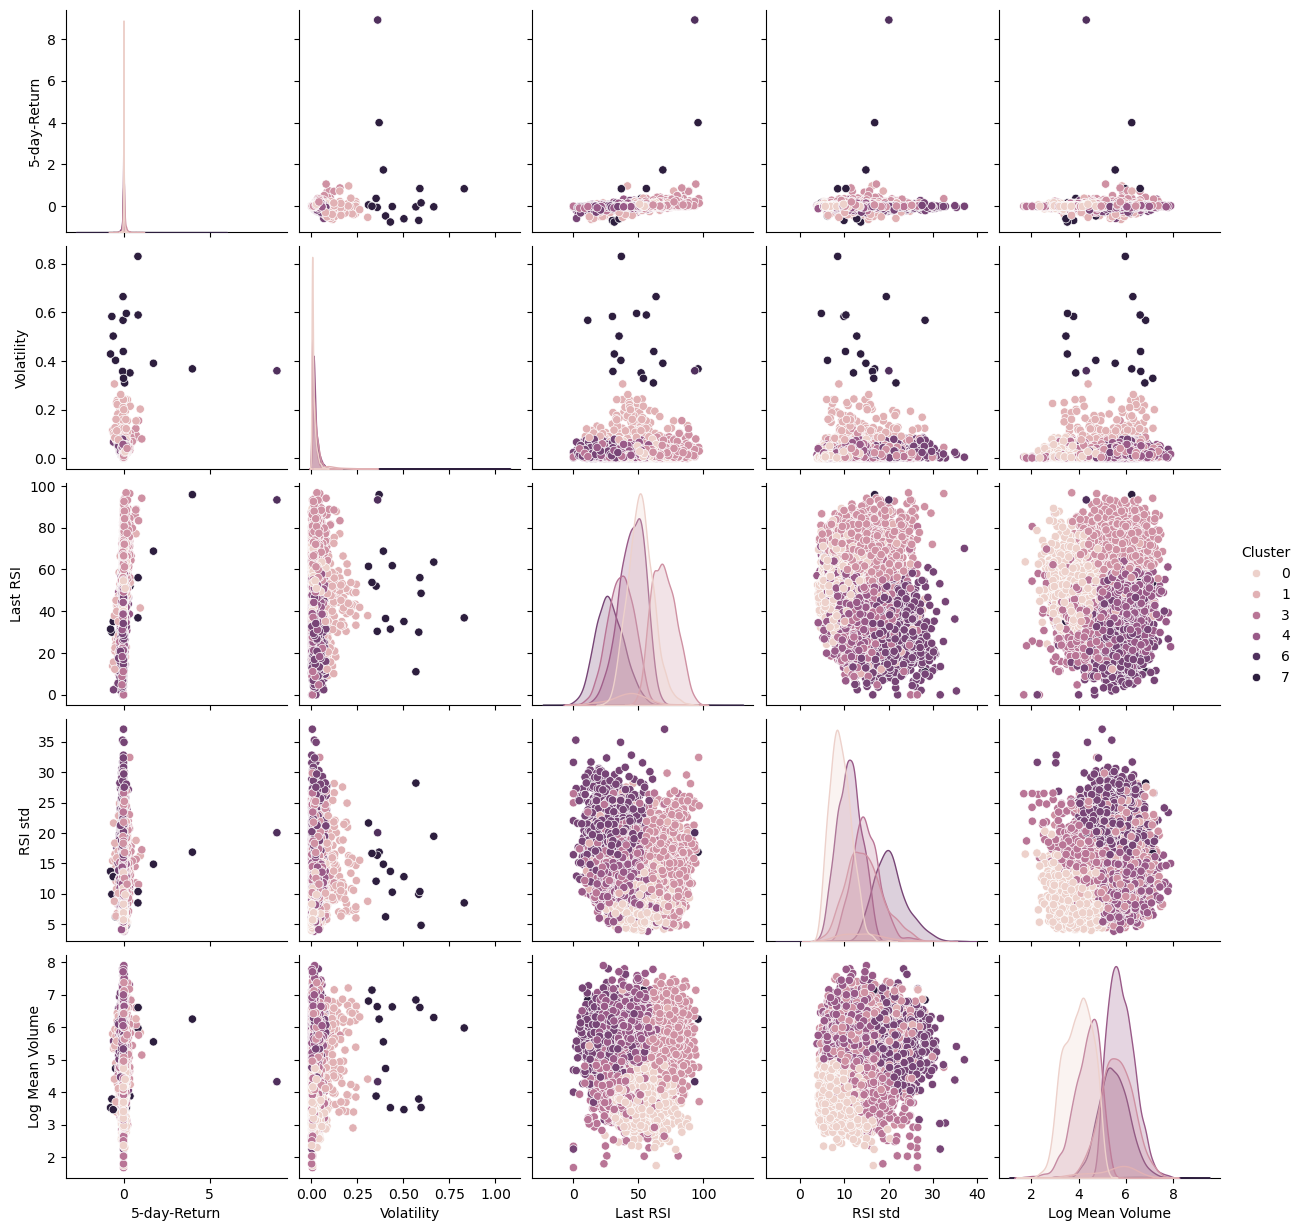

-----------------------------------------9 means clustering----------------------------


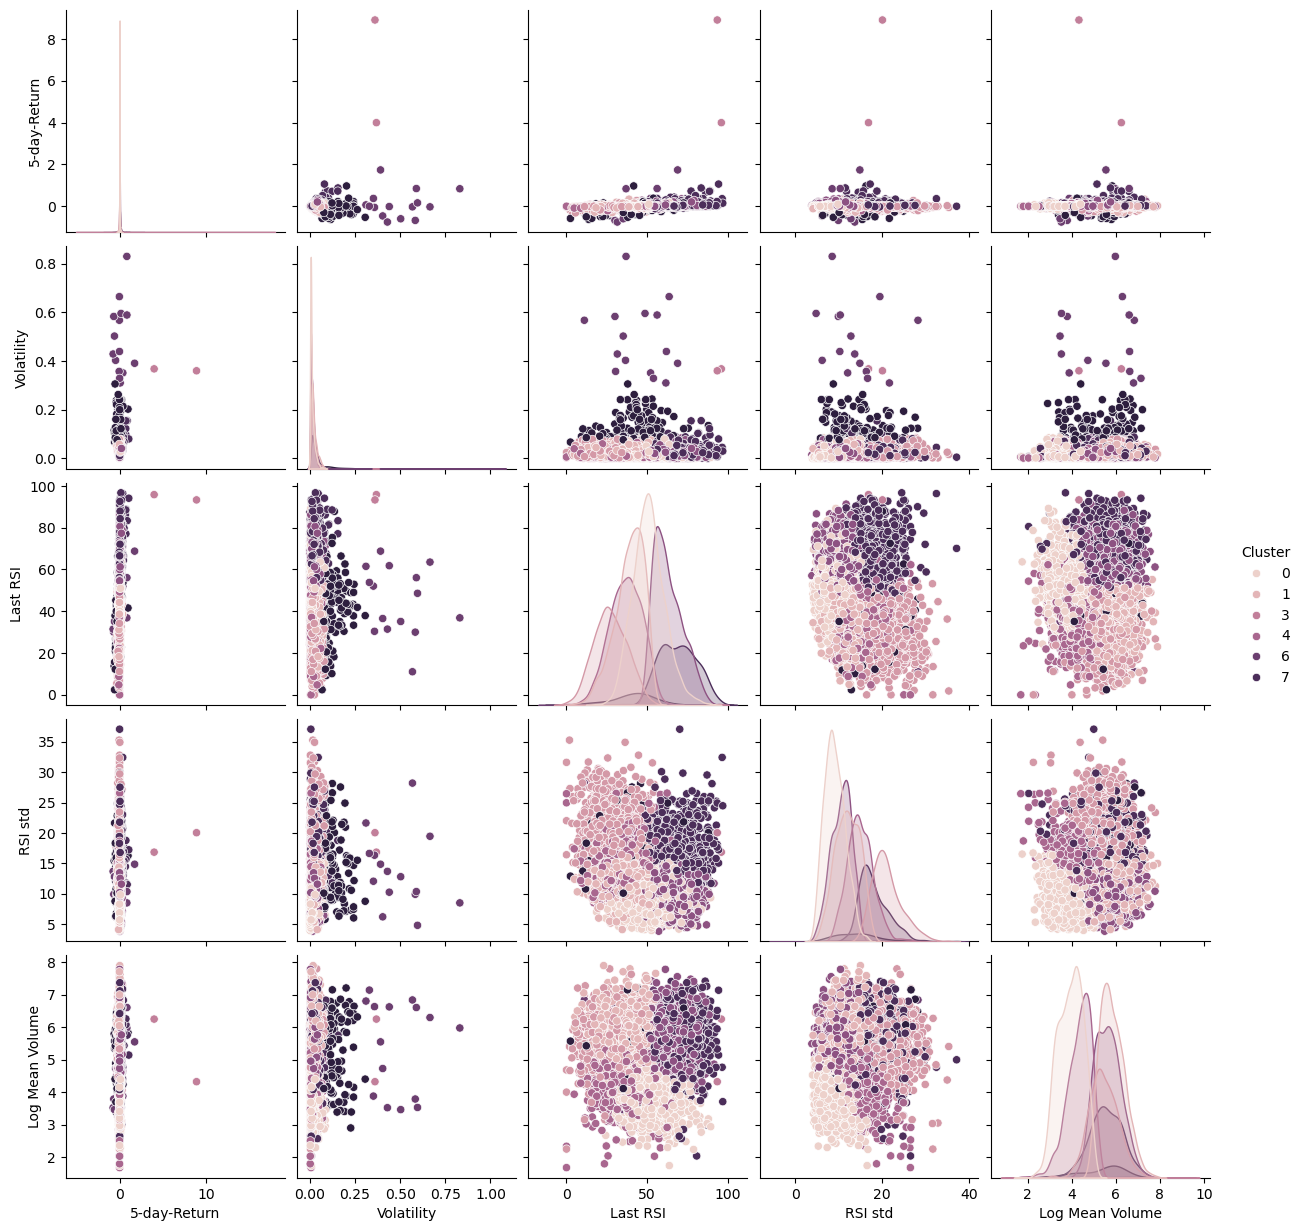

In [21]:
# Perform KNN on the df dataset
inertia = []
silhouette = []
scaler = StandardScaler()
for i in range(2,10):
    scaled_df = scaler.fit_transform(df)
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

    silhouette.append(silhouette_score(scaled_df, kmeans.labels_))
    print(f"-----------------------------------------{i} means clustering----------------------------")
    labelled = df.copy()
    labelled["Cluster"] = kmeans.labels_
    sns.pairplot(labelled, hue='Cluster', diag_kind='kde')
    plt.show()